In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
import glob

import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

In [73]:
data_path = "/Users/olicho/Desktop/Programming/adversarial-style-transfer/data/source_images"

total_images = 0
for folder in os.listdir(data_path):
    if os.path.isdir(os.path.join(data_path, folder)):
        folder_path = os.path.join(data_path, folder)
        images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        print(f"{folder}: {len(images)} images")
        total_images += len(images)
print(f"\nTotal images across all folders: {total_images}")

chainsaw: 858 images
gas_pump: 931 images
tench: 963 images
french_horn: 956 images
church: 941 images
english_springer: 955 images
golf_ball: 951 images
garbage_truck: 961 images
parachute: 960 images
cassette_player: 993 images

Total images across all folders: 9469


# Data Preprocessing

In [14]:
data_path = "/Users/olicho/Desktop/Programming/adversarial-style-transfer/data/source_images"

def rename_images(base_path):

    subfolders = [f for f in os.listdir(base_path)]

    for subfolder in subfolders:
        subfolder_path = os.path.join(base_path, subfolder)

        files = glob.glob(os.path.join(subfolder_path, "*"))

        for i, file_path in enumerate(files):
            _, ext = os.path.splitext(file_path)
            new_path = os.path.join(subfolder_path, f"{subfolder}_{i}{ext}")
            os.rename(file_path, new_path)

rename_images(data_path)

In [48]:
def load_and_preprocess_images(data_path, target_size=(64, 64)):
    images = []
    labels = []
    label_map = {}
    
    # Get all subfolders (classes)
    subfolders = [f for f in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, f))]
    
    # Create label mapping
    for idx, folder in enumerate(subfolders):
        label_map[folder] = idx
    
    # Load and preprocess images from each subfolder
    for subfolder in subfolders:
        subfolder_path = os.path.join(data_path, subfolder)
        files = glob.glob(os.path.join(subfolder_path, "*"))
        
        for file_path in tqdm.tqdm(files, desc=f"Processing {subfolder}"):
            # Load image
            img = Image.open(file_path).convert('RGB')  # Ensure RGB format
            
            # Resize 
            img = img.resize(target_size, Image.LANCZOS)
            
            # Convert to numpy array and normalize
            img_array = np.array(img) / 255.0
            
            images.append(img_array)
            labels.append(label_map[subfolder])
    
    # Convert to numpy arrays
    X = np.array(images)
    y = np.array(labels)
    
    # Reshape for PyTorch (N, C, H, W)
    X = X.transpose(0, 3, 1, 2)  # Rearrange from (N, H, W, C) to (N, C, H, W)
    
    return X, y, label_map

# Load and preprocess all images
X, y, label_map = load_and_preprocess_images(data_path)

# First split into train and temp (80-20)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Split temp into validation and test (50-50, meaning 10-10 of original data)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_val = torch.LongTensor(y_val)
y_test = torch.LongTensor(y_test)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"\nClass mapping: {label_map}")


Processing cassette_player: 100%|██████████| 993/993 [00:01<00:00, 749.97it/s]


Training set shape: torch.Size([7575, 3, 64, 64])
Validation set shape: torch.Size([947, 3, 64, 64])
Test set shape: torch.Size([947, 3, 64, 64])

Class mapping: {'chainsaw': 0, 'gas_pump': 1, 'tench': 2, 'french_horn': 3, 'church': 4, 'english_springer': 5, 'golf_ball': 6, 'garbage_truck': 7, 'parachute': 8, 'cassette_player': 9}


In [49]:
print(X_train.shape + X_test.shape + X_val.shape)

torch.Size([7575, 3, 64, 64, 947, 3, 64, 64, 947, 3, 64, 64])


In [50]:
# Create data loaders
batch_size = 32

# Create datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Model Architecture

In [56]:
class ObjectRecognition(nn.Module):
    def __init__(self):
        super(ObjectRecognition, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 32x32x32
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 64x16x16
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.mp3 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 128x8x8

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

        self.dropout = nn.Dropout(0.4)

        self.fc1 = nn.Linear(8192, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10) # 10 classes

        self.relu = nn.ReLU()

    def forward(self, x):
        # Input shape: Bx3x64x64
        x = self.mp1(self.bn1(self.relu(self.conv1(x))))  # Bx32x32x32
        x = self.mp2(self.bn2(self.relu(self.conv2(x))))  # Bx64x16x16
        x = self.mp3(self.bn3(self.relu(self.conv3(x))))  # Bx128x8x8

        x = torch.flatten(x, 1)  # Bx(128*8*8)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))  # Bx512
        x = self.dropout(x)
        x = self.relu(self.fc2(x))  # Bx128
        x = self.fc3(x)  # Bx10

        return x

# Training

In [68]:
model = ObjectRecognition()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.00001)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
epochs = 8

In [71]:
train_losses = []
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    # Progress bar for training batches
    progress_bar = tqdm.tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
    
    for images, labels in progress_bar:
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Update running loss
        running_loss += loss.item()
        
        # Update progress bar description with current loss
        progress_bar.set_postfix({'loss': loss.item()})
    
    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    
    print(f'Epoch [{epoch+1}/{epochs}] - Loss: {epoch_loss:.4f}')

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/8:   9%|▉         | 21/237 [00:02<00:24,  8.94it/s, loss=0.487]


KeyboardInterrupt: 

# Download model weights

In [14]:
# # Save model weights
# model_save_path = '/Users/olicho/Desktop/Programming/adversarial-style-transfer/models-weights/object_detection/model_weights_15_epochs.pth'
# torch.save(model.state_dict(), model_save_path)
# print(f"Model weights saved to {model_save_path}")

Model weights saved to /Users/olicho/Desktop/Programming/adversarial-style-transfer/models-weights/object_detection/model_weights_15_epochs.pth


# Validation

In [ ]:
# Load saved model weights
# model_weights_path = '/Users/olicho/Desktop/Programming/adversarial-style-transfer/models-weights/object-detection-nonadversarial/model_weights.pth'
# model.load_state_dict(torch.load(model_weights_path))
# print(f"Model weights loaded from {model_weights_path}")

Model weights loaded from /Users/olicho/Desktop/Programming/adversarial-style-transfer/models-weights/object-detection-nonadversarial/model_weights.pth


In [70]:
def evaluate_model(model, test_loader):

    model.eval()

    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)

            loss = criterion(output, target)
            test_loss += loss.item()

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

    test_loss /= len(test_loader)

    return {
        'loss': test_loss,
        'accuracy': correct / total,
    }

# Evaluate model on test set
test_results = evaluate_model(model, test_loader)
print(f"Test Loss: {test_results['loss']:.4f}")
print(f"Test Accuracy: {test_results['accuracy']:.4f}")

Test Loss: 6.8033
Test Accuracy: 0.3178


In [64]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import pandas as pd

class_names = ['chainsaw', 'gas_pump', 'tench', 'french_horn', 'church', 'english_springer', 'golf_ball', 'garbage_truck', 'parachute', 'cassette_player']

# Get predictions and true labels for entire test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        pred = output.argmax(dim=1)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

# Calculate metrics for each class
precision, recall, f1, support = precision_recall_fscore_support(
    all_labels, 
    all_preds,
    labels=range(len(class_names)),
    average=None
)

# Create DataFrame with results
results_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

# Calculate accuracy for each class from confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
results_df['Accuracy'] = class_accuracy

# Display results with nice formatting
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))
print("\nPer-class Performance Metrics:")
print(results_df)

# Calculate and display macro averages
macro_avg = results_df[['Precision', 'Recall', 'F1-Score', 'Accuracy']].mean()
print("\nMacro Averages:")
for metric, value in macro_avg.items():
    print(f"{metric}: {value:.3f}")


Per-class Performance Metrics:
              Class  Precision  Recall  F1-Score  Support  Accuracy
0          chainsaw      0.500   0.465     0.482       86     0.465
1          gas_pump      0.560   0.602     0.580       93     0.602
2             tench      0.758   0.742     0.750       97     0.742
3       french_horn      0.630   0.842     0.721       95     0.842
4            church      0.742   0.766     0.754       94     0.766
5  english_springer      0.704   0.719     0.711       96     0.719
6         golf_ball      0.696   0.579     0.632       95     0.579
7     garbage_truck      0.703   0.740     0.721       96     0.740
8         parachute      0.848   0.812     0.830       96     0.812
9   cassette_player      0.782   0.616     0.689       99     0.616

Macro Averages:
Precision: 0.692
Recall: 0.688
F1-Score: 0.687
Accuracy: 0.688


In [79]:
# # Save model weights
model_save_path = '/Users/olicho/Desktop/Programming/adversarial-style-transfer/models-weights/object_detection/model_weights_8_epochs.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model weights saved to {model_save_path}")

Model weights saved to /Users/olicho/Desktop/Programming/adversarial-style-transfer/models-weights/object_detection/model_weights_8_epochs.pth


# Stylized Evaluation

In [92]:
class_names = list(label_map.keys())

# Create a dictionary to store results for each class
results = {class_name: [] for class_name in class_names}

# Process each class
for class_name in class_names:
    # Get all images for this class from processed folder
    class_path = os.path.join('/Users/olicho/Desktop/Programming/adversarial-style-transfer/data/processed', class_name)
    images = glob.glob(os.path.join(class_path, '*.jpg'))
    
    print(f"\nEvaluating {class_name}...")
    
    # Process each image
    for img_path in list(images):  # Convert glob iterator to list before iterating
        # Load and preprocess image
        img = Image.open(img_path).convert('RGB')
        img = img.resize((64, 64), Image.LANCZOS)
        img_array = np.array(img) / 255.0
        img_tensor = torch.from_numpy(img_array.transpose(2, 0, 1)).float()
        img_tensor = img_tensor.unsqueeze(0)
        
        # Get model prediction
        model.eval()
        with torch.no_grad():
            output = model(img_tensor)
            probs = torch.nn.functional.softmax(output, dim=1)[0]
            # Get top 3 predictions
            top3_prob, top3_idx = torch.topk(probs, 3)
            
        results[class_name].append({
            'top3_classes': [class_names[idx] for idx in top3_idx],
            'top3_confidences': [prob.item() for prob in top3_prob]
        })

# Print summary for each class
print("\nEvaluation Results:")
for class_name, predictions in results.items():
    total = len(predictions)
    
    # Calculate accuracy (when true class is top prediction)
    correct = sum(1 for p in predictions if p['top3_classes'][0] == class_name)
    accuracy = correct / total
    
    # Calculate average confidence of top prediction
    avg_confidence = sum(p['top3_confidences'][0] for p in predictions) / total
    
    # Count frequency of each predicted class
    prediction_counts = {}
    for p in predictions:
        for pred_class in p['top3_classes']:
            prediction_counts[pred_class] = prediction_counts.get(pred_class, 0) + 1
    
    # Get top 3 most common predictions
    most_common = sorted(prediction_counts.items(), key=lambda x: x[1], reverse=True)[:3]
    
    print(f"\n{class_name}:")
    print(f"Accuracy: {accuracy:.2%}")
    print(f"Average Confidence: {avg_confidence:.2%}")
    print("Most commonly predicted as:")
    for pred_class, count in most_common:
        percentage = count / (total * 3) * 100  # Divide by total*3 since each image has 3 predictions
        print(f"  - {pred_class}: {percentage:.1f}% of predictions")


Evaluating chainsaw...

Evaluating gas_pump...

Evaluating tench...

Evaluating french_horn...

Evaluating church...

Evaluating english_springer...

Evaluating golf_ball...

Evaluating garbage_truck...

Evaluating parachute...

Evaluating cassette_player...

Evaluation Results:

chainsaw:
Accuracy: 2.38%
Average Confidence: 85.20%
Most commonly predicted as:
  - golf_ball: 30.9% of predictions
  - parachute: 24.3% of predictions
  - tench: 15.2% of predictions

gas_pump:
Accuracy: 0.00%
Average Confidence: 86.70%
Most commonly predicted as:
  - golf_ball: 31.9% of predictions
  - parachute: 25.6% of predictions
  - tench: 18.3% of predictions

tench:
Accuracy: 10.52%
Average Confidence: 85.35%
Most commonly predicted as:
  - golf_ball: 32.1% of predictions
  - tench: 30.6% of predictions
  - parachute: 24.5% of predictions

french_horn:
Accuracy: 9.20%
Average Confidence: 88.03%
Most commonly predicted as:
  - golf_ball: 32.2% of predictions
  - parachute: 23.1% of predictions
  - te

# Make training dataset 50% original and 50% stylized. Validate on 100% original images

In [102]:
original_data_path = "/Users/olicho/Desktop/Programming/adversarial-style-transfer/data/source_images"
stylized_data_path = "/Users/olicho/Desktop/Programming/adversarial-style-transfer/data/processed"

X_orig, y_orig, label_map = load_and_preprocess_images(original_data_path)
X_style, y_style, _ = load_and_preprocess_images(stylized_data_path)

print(f"Original data: {len(X_orig)} images")
print(f"Stylized data: {len(X_style)} images")

# Set random seed for reproducibility
np.random.seed(42)

# Randomly subsample stylized data to match original data size
subset_size = len(X_orig)
style_indices = np.random.choice(len(X_style), subset_size, replace=False)
X_style_subset = X_style[style_indices]
y_style_subset = y_style[style_indices]

print(f"Stylized subset: {len(X_style_subset)} images (randomly sampled)")

# Split original data into train, val and test
X_orig_train, X_orig_temp, y_orig_train, y_orig_temp = train_test_split(
    X_orig, y_orig, test_size=0.2, random_state=42, stratify=y_orig
)
X_orig_val, X_orig_test, y_orig_val, y_orig_test = train_test_split(
    X_orig_temp, y_orig_temp, test_size=0.5, random_state=42, stratify=y_orig_temp
)

# Split stylized subset - we only need training portion
X_style_train, _, y_style_train, _ = train_test_split(
    X_style_subset, y_style_subset, test_size=0.2, random_state=42, stratify=y_style_subset
)

# Combine original and stylized for training (true 50-50 split)
X_train = np.concatenate([X_orig_train, X_style_train])
y_train = np.concatenate([y_orig_train, y_style_train])

# Use original data only for validation and test
X_val = X_orig_val
y_val = y_orig_val
X_test = X_orig_test 
y_test = y_orig_test

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_val = torch.LongTensor(y_val)
y_test = torch.LongTensor(y_test)

print(f"\nFinal dataset sizes:")
print(f"Training set shape: {X_train.shape} (50% original: {len(X_orig_train)}, 50% stylized: {len(X_style_train)})")
print(f"Validation set shape: {X_val.shape} (100% original)")
print(f"Test set shape: {X_test.shape} (100% original)")
print(f"\nClass mapping: {label_map}")

# Verify class balance in training set
print(f"\nTraining set class distribution:")
unique_train, counts_train = np.unique(y_train.numpy(), return_counts=True)
for class_idx, count in zip(unique_train, counts_train):
    class_name = [k for k, v in label_map.items() if v == class_idx][0]
    print(f"  {class_name}: {count} images")

Processing cassette_player: 100%|██████████| 2500/2500 [00:05<00:00, 440.37it/s]


Original data: 9469 images
Stylized data: 23777 images
Stylized subset: 9469 images (randomly sampled)

Final dataset sizes:
Training set shape: torch.Size([15150, 3, 64, 64]) (50% original: 7575, 50% stylized: 7575)
Validation set shape: torch.Size([947, 3, 64, 64]) (100% original)
Test set shape: torch.Size([947, 3, 64, 64]) (100% original)

Class mapping: {'chainsaw': 0, 'gas_pump': 1, 'tench': 2, 'french_horn': 3, 'church': 4, 'english_springer': 5, 'golf_ball': 6, 'garbage_truck': 7, 'parachute': 8, 'cassette_player': 9}

Training set class distribution:
  chainsaw: 1346 images
  gas_pump: 1507 images
  tench: 1532 images
  french_horn: 1555 images
  church: 1501 images
  english_springer: 1522 images
  golf_ball: 1504 images
  garbage_truck: 1554 images
  parachute: 1554 images
  cassette_player: 1575 images


In [103]:
# Create data loaders
batch_size = 32

# Create datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Epoch 1/8: 100%|██████████| 474/474 [00:54<00:00,  8.77it/s, loss=0.133]  


Epoch [1/8] - Loss: 0.1543


Epoch 2/8: 100%|██████████| 474/474 [00:51<00:00,  9.22it/s, loss=0.148]  


Epoch [2/8] - Loss: 0.1113


Epoch 3/8: 100%|██████████| 474/474 [00:50<00:00,  9.43it/s, loss=0.275]  


Epoch [3/8] - Loss: 0.1012


Epoch 4/8: 100%|██████████| 474/474 [00:50<00:00,  9.46it/s, loss=0.136]  


Epoch [4/8] - Loss: 0.0989


Epoch 5/8: 100%|██████████| 474/474 [00:50<00:00,  9.45it/s, loss=0.00589]


Epoch [5/8] - Loss: 0.0871


Epoch 6/8: 100%|██████████| 474/474 [00:50<00:00,  9.45it/s, loss=0.0469] 


Epoch [6/8] - Loss: 0.0876


Epoch 7/8: 100%|██████████| 474/474 [02:01<00:00,  3.90it/s, loss=0.147]  


Epoch [7/8] - Loss: 0.0740


Epoch 8/8: 100%|██████████| 474/474 [09:35<00:00,  1.21s/it, loss=0.0121]   


Epoch [8/8] - Loss: 0.0781


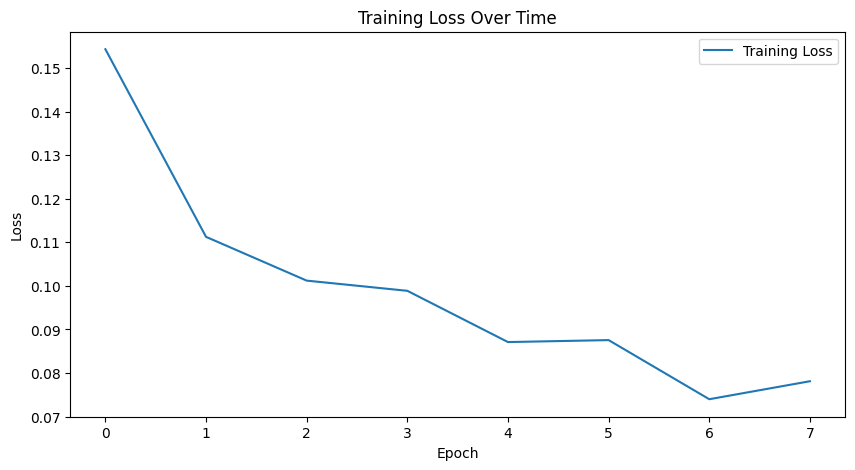

In [104]:
train_losses = []
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    # Progress bar for training batches
    progress_bar = tqdm.tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
    
    for images, labels in progress_bar:
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Update running loss
        running_loss += loss.item()
        
        # Update progress bar description with current loss
        progress_bar.set_postfix({'loss': loss.item()})
    
    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    
    print(f'Epoch [{epoch+1}/{epochs}] - Loss: {epoch_loss:.4f}')

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [105]:
# Save model weights
model_save_path = '/Users/olicho/Desktop/Programming/adversarial-style-transfer/models-weights/object_detection/50-50-model-weights.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model weights saved to {model_save_path}")

Model weights saved to /Users/olicho/Desktop/Programming/adversarial-style-transfer/models-weights/object_detection/50-50-model-weights.pth


In [106]:
test_results = evaluate_model(model, test_loader)
print(f"Test Loss: {test_results['loss']:.4f}")
print(f"Test Accuracy: {test_results['accuracy']:.4f}")

Test Loss: 1.2167
Test Accuracy: 0.7994


In [107]:
class_names = ['chainsaw', 'gas_pump', 'tench', 'french_horn', 'church', 'english_springer', 'golf_ball', 'garbage_truck', 'parachute', 'cassette_player']

# Get predictions and true labels for entire test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        pred = output.argmax(dim=1)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

# Calculate metrics for each class
precision, recall, f1, support = precision_recall_fscore_support(
    all_labels, 
    all_preds,
    labels=range(len(class_names)),
    average=None
)

# Create DataFrame with results
results_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

# Calculate accuracy for each class from confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
results_df['Accuracy'] = class_accuracy

# Display results with nice formatting
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))
print("\nPer-class Performance Metrics:")
print(results_df)

# Calculate and display macro averages
macro_avg = results_df[['Precision', 'Recall', 'F1-Score', 'Accuracy']].mean()
print("\nMacro Averages:")
for metric, value in macro_avg.items():
    print(f"{metric}: {value:.3f}")


Per-class Performance Metrics:
              Class  Precision  Recall  F1-Score  Support  Accuracy
0          chainsaw      0.778   0.651     0.709       86     0.651
1          gas_pump      0.752   0.817     0.784       93     0.817
2             tench      0.899   0.825     0.860       97     0.825
3       french_horn      0.728   0.789     0.758       95     0.789
4            church      0.809   0.809     0.809       94     0.809
5  english_springer      0.825   0.833     0.829       96     0.833
6         golf_ball      0.857   0.758     0.804       95     0.758
7     garbage_truck      0.714   0.885     0.791       96     0.885
8         parachute      0.837   0.854     0.845       96     0.854
9   cassette_player      0.833   0.758     0.794       99     0.758

Macro Averages:
Precision: 0.803
Recall: 0.798
F1-Score: 0.798
Accuracy: 0.798


In [108]:
class_names = list(label_map.keys())

# Create a dictionary to store results for each class
results = {class_name: [] for class_name in class_names}

# Process each class
for class_name in class_names:
    # Get all images for this class from processed folder
    class_path = os.path.join('/Users/olicho/Desktop/Programming/adversarial-style-transfer/data/processed', class_name)
    images = glob.glob(os.path.join(class_path, '*.jpg'))
    
    print(f"\nEvaluating {class_name}...")
    
    # Process each image
    for img_path in list(images):  # Convert glob iterator to list before iterating
        # Load and preprocess image
        img = Image.open(img_path).convert('RGB')
        img = img.resize((64, 64), Image.LANCZOS)
        img_array = np.array(img) / 255.0
        img_tensor = torch.from_numpy(img_array.transpose(2, 0, 1)).float()
        img_tensor = img_tensor.unsqueeze(0)
        
        # Get model prediction
        model.eval()
        with torch.no_grad():
            output = model(img_tensor)
            probs = torch.nn.functional.softmax(output, dim=1)[0]
            # Get top 3 predictions
            top3_prob, top3_idx = torch.topk(probs, 3)
            
        results[class_name].append({
            'top3_classes': [class_names[idx] for idx in top3_idx],
            'top3_confidences': [prob.item() for prob in top3_prob]
        })

# Print summary for each class
print("\nEvaluation Results:")
for class_name, predictions in results.items():
    total = len(predictions)
    
    # Calculate accuracy (when true class is top prediction)
    correct = sum(1 for p in predictions if p['top3_classes'][0] == class_name)
    accuracy = correct / total
    
    # Calculate average confidence of top prediction
    avg_confidence = sum(p['top3_confidences'][0] for p in predictions) / total
    
    # Count frequency of each predicted class
    prediction_counts = {}
    for p in predictions:
        for pred_class in p['top3_classes']:
            prediction_counts[pred_class] = prediction_counts.get(pred_class, 0) + 1
    
    # Get top 3 most common predictions
    most_common = sorted(prediction_counts.items(), key=lambda x: x[1], reverse=True)[:3]
    
    print(f"\n{class_name}:")
    print(f"Accuracy: {accuracy:.2%}")
    print(f"Average Confidence: {avg_confidence:.2%}")
    print("Most commonly predicted as:")
    for pred_class, count in most_common:
        percentage = count / (total * 3) * 100  # Divide by total*3 since each image has 3 predictions
        print(f"  - {pred_class}: {percentage:.1f}% of predictions")


Evaluating chainsaw...

Evaluating gas_pump...

Evaluating tench...

Evaluating french_horn...

Evaluating church...

Evaluating english_springer...

Evaluating golf_ball...

Evaluating garbage_truck...

Evaluating parachute...

Evaluating cassette_player...

Evaluation Results:

chainsaw:
Accuracy: 98.74%
Average Confidence: 97.43%
Most commonly predicted as:
  - chainsaw: 33.3% of predictions
  - english_springer: 13.3% of predictions
  - parachute: 11.3% of predictions

gas_pump:
Accuracy: 99.44%
Average Confidence: 98.81%
Most commonly predicted as:
  - gas_pump: 33.3% of predictions
  - garbage_truck: 11.2% of predictions
  - church: 9.3% of predictions

tench:
Accuracy: 99.25%
Average Confidence: 98.25%
Most commonly predicted as:
  - tench: 33.3% of predictions
  - golf_ball: 11.9% of predictions
  - french_horn: 10.6% of predictions

french_horn:
Accuracy: 99.26%
Average Confidence: 98.05%
Most commonly predicted as:
  - french_horn: 33.3% of predictions
  - golf_ball: 12.5% o